In [4]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX
import os 

# Auxiliary Functions

In [5]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_new import vit_base_patch16_224 
from baselines.ViT.ViT_orig_LRP import vit_base_patch16_224 as vit_orig_LRP
from baselines.ViT.ViT_explanation_generator import LRP,IBA

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = IBA(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="IBA",start_layer=1, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

# Examples

## Cat-Dog

Top 5 classes:
	349 : bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis		value = 7.911	 prob = 21.3%
	340 : zebra                                                                                          		value = 7.884	 prob = 20.7%
	354 : Arabian camel, dromedary, Camelus dromedarius                                                  		value = 7.260	 prob = 11.1%
	386 : African elephant, Loxodonta africana                                                           		value = 6.818	 prob = 7.1%
	355 : llama                                                                                          		value = 6.764	 prob = 6.8%


(-0.5, 223.5, 223.5, -0.5)

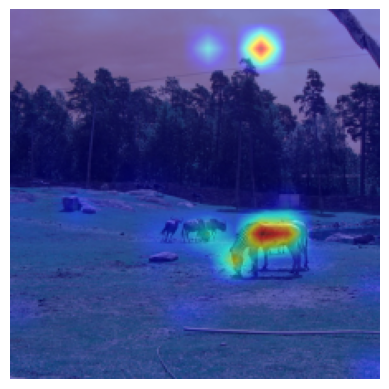

In [6]:
image = Image.open('samples/000000016010.jpg')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	340 : zebra                               		value = 14.033	 prob = 99.8%
	9 : ostrich, Struthio camelus           		value = 5.801	 prob = 0.0%
	353 : gazelle                             		value = 5.553	 prob = 0.0%
	386 : African elephant, Loxodonta africana		value = 5.207	 prob = 0.0%
	352 : impala, Aepyceros melampus          		value = 4.407	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

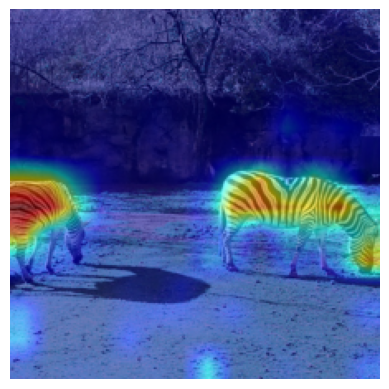

In [8]:
image = Image.open('samples/000000020059.jpg')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=340)

axs.imshow(dog,cmap='gray')
axs.axis('off')

Top 5 classes:
	386 : African elephant, Loxodonta africana         		value = 13.953	 prob = 83.3%
	385 : Indian elephant, Elephas maximus             		value = 12.281	 prob = 15.7%
	101 : tusker                                       		value = 9.426	 prob = 0.9%
	354 : Arabian camel, dromedary, Camelus dromedarius		value = 4.808	 prob = 0.0%
	340 : zebra                                        		value = 4.332	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

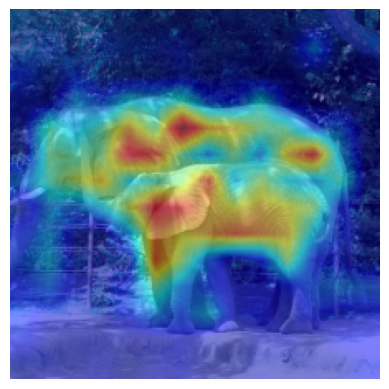

In [10]:
image = Image.open('samples/000000080274.jpg')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	386 : African elephant, Loxodonta africana		value = 12.563	 prob = 47.9%
	385 : Indian elephant, Elephas maximus    		value = 12.343	 prob = 38.4%
	101 : tusker                              		value = 11.285	 prob = 13.3%
	343 : warthog                             		value = 5.295	 prob = 0.0%
	347 : bison                               		value = 4.739	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

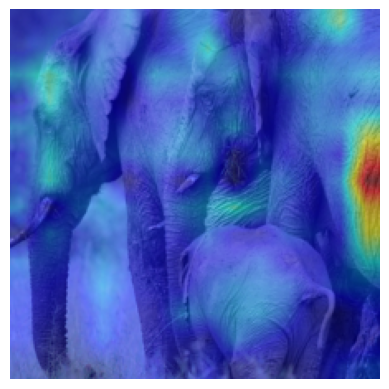

In [11]:
image = Image.open('samples/000000167128.jpg')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	18 : magpie                                 		value = 9.573	 prob = 59.8%
	88 : macaw                                  		value = 7.774	 prob = 9.9%
	136 : European gallinule, Porphyrio porphyrio		value = 7.257	 prob = 5.9%
	131 : little blue heron, Egretta caerulea    		value = 6.602	 prob = 3.1%
	92 : bee eater                              		value = 6.251	 prob = 2.2%


(-0.5, 223.5, 223.5, -0.5)

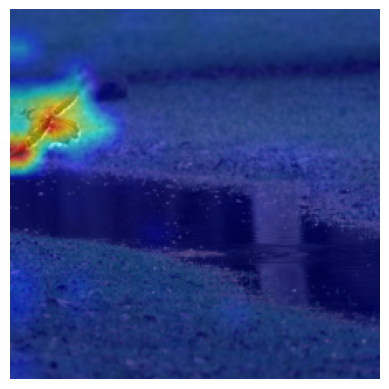

In [12]:
image = Image.open('samples/ILSVRC2012_val_00004317.JPEG')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	128 : black stork, Ciconia nigra  		value = 15.563	 prob = 95.5%
	127 : white stork, Ciconia ciconia		value = 12.487	 prob = 4.4%
	134 : crane                       		value = 6.222	 prob = 0.0%
	135 : limpkin, Aramus pictus      		value = 5.187	 prob = 0.0%
	21 : kite                        		value = 5.068	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

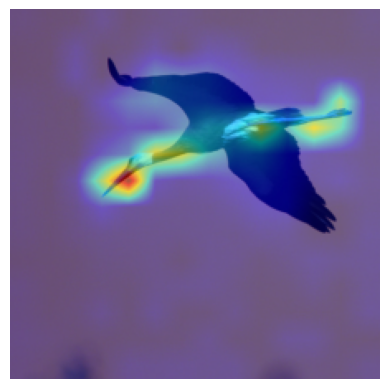

In [14]:
image = Image.open('samples/ILSVRC2012_val_00032580.JPEG')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	139 : ruddy turnstone, Arenaria interpres        		value = 14.566	 prob = 99.6%
	140 : red-backed sandpiper, dunlin, Erolia alpina		value = 8.013	 prob = 0.1%
	141 : redshank, Tringa totanus                   		value = 7.593	 prob = 0.1%
	143 : oystercatcher, oyster catcher              		value = 7.269	 prob = 0.1%
	142 : dowitcher                                  		value = 6.938	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

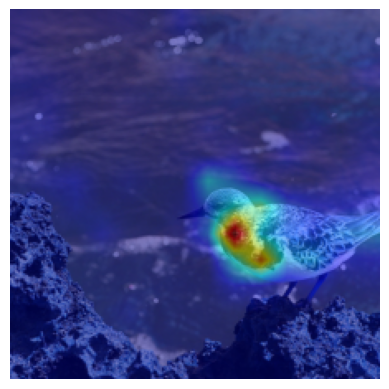

In [17]:
image = Image.open('samples/ILSVRC2012_val_00039363.JPEG')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')

Top 5 classes:
	153 : Maltese dog, Maltese terrier, Maltese		value = 14.517	 prob = 99.6%
	204 : Lhasa, Lhasa apso                    		value = 7.867	 prob = 0.1%
	200 : Tibetan terrier, chrysanthemum dog   		value = 7.305	 prob = 0.1%
	155 : Shih-Tzu                             		value = 6.347	 prob = 0.0%
	265 : toy poodle                           		value = 6.014	 prob = 0.0%


(-0.5, 223.5, 223.5, -0.5)

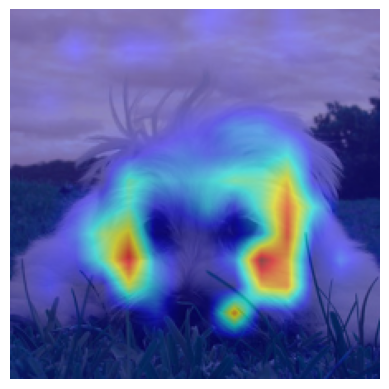

In [19]:
image = Image.open('samples/ILSVRC2012_val_00029546.JPEG')
dog_cat_image = transform(image)

fig, axs = plt.subplots()
# axs[0].imshow(image);
# axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)

axs.imshow(cat,cmap='gray')
axs.axis('off')